Biblioteka `laspy` jest używana do pracy z plikami formatu LAS, które są szeroko stosowane w przetwarzaniu chmur punktów i danych LiDAR.
`numpy` jest potężną biblioteką do obliczeń numerycznych w Pythonie, oferującą wsparcie dla wielowymiarowych tablic, operacji matematycznych, przetwarzania danych i wiele innych funkcji przydatnych w analizie i manipulacji danymi.

`matplotlib` jest popularną biblioteką do tworzenia wykresów i wizualizacji danych. Jest często wykorzystywana do generowania różnych typów wykresów, histogramów, diagramów punktowych itp.

`mpl_toolkits` jest narzędziem rozszerzającym bibliotekę `matplotlib`, które zapewnia funkcjonalność do tworzenia wykresów trójwymiarowych. Jest przydatne do wizualizacji danych w przestrzeni trójwymiarowej.

`scipy.optimize.minimize` jest częścią biblioteki scipy i oferuje różne metody optymalizacji numerycznej. W tym konkretnym przypadku jest używana do minimalizacji funkcji celu w celu znalezienia optymalnych parametrów.

In [1]:
import laspy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

Poniższy fragment kodu definiuje klasę o nazwie "Plaster". Klasa ta ma kilka metod, które wykonują różne operacje na punktach plastra.

Metoda __init__ jest konstruktorem klasy. Przyjmuje ona dwa argumenty: `points`, który reprezentuje punkty na plastrze, i `plaster_number`, który reprezentuje numer tego plastra.

Metoda `get_num_points()` zwraca liczbę punktów na plastrze, używając funkcji wbudowanej w pythonie funkcji `len()`.

Metoda `interpolate_circle()` służy do interpolacji okręgu na podstawie punktów na plastrze. Jeśli liczba punktów jest mniejsza niż 3, metoda zwraca `None, None`.
Następnie, metoda tworzy zmienne x, y, z na podstawie wartości w punktach. Wykorzystuje one dane z punktów, gdzie x to współrzędna x, y to współrzędna y, a z to współrzędna z. Funkcja `objective_function()` jest zagnieżdżoną funkcją w metodzie `interpolate_circle`, która przyjmuje argument `center_radius`, który reprezentuje środek okręgu i promień. Oblicza ona odległość każdego punktu od tego okręgu i zwraca sumę kwadratów tych odległości.
Następnie tworzona jest lista `center_radius_guess`, która zawiera przybliżone wartości dla środka okręgu i promienia. Środek okręgu to średnia wartość współrzędnych x i y, a promień to odchylenie standardowe wartości x.
Następnie wywoływana jest funkcja `minimize`, która minimalizuje wartość funkcji `objective_function` dla danego przybliżenia `center_radius_guess`. Wynik tej minimalizacji jest przechowywany w zmiennej `result`.
Następnie, z wyniku `result` pobierane są wartości dla środka okręgu (center) oraz promienia (radius). Dodatkowo obliczane jest odchylenie (deviation) na podstawie wartości minimalnej funkcji i liczby punktów.

Na koniec, metoda `interpolate_circle` zwraca obliczone odchylenie i środek okręgu w postaci listy `deviation, center`.

In [2]:
class Plaster:
    def __init__(self, points, plaster_number):
        self.points = points
        self.plaster_number = plaster_number

    def get_num_points(self):
        return len(self.points)

    def interpolate_circle(self):
        if len(self.points) < 3:
            return None, None

        x = self.points["x"]
        y = self.points["y"]
        z = self.points["z"]

        def objective_function(center_radius):
            cx, cy, r = center_radius
            distance = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
            return np.sum((distance - r) ** 2)

        center_radius_guess = [np.mean(x), np.mean(y), np.std(x)]


        result = minimize(objective_function, center_radius_guess, method='Nelder-Mead')
        center = result.x.tolist()
        center.append(np.mean(z))
        radius = result.x[2]
        deviation = np.sqrt(result.fun / len(self.points))

        return list(deviation, center)


Poniższy fragmentu kodu definiuje klasę o nazwie `PointCloud`, która reprezentuje chmurę punktów. Klasa ta ma trzy metody.

Metoda `__init__` jest konstruktorem klasy. Przyjmuje ona argument `filename`, który reprezentuje nazwę pliku chmury punktów. Metoda inicjalizuje atrybut `filename` dla danego obiektu klasy i ustawia atrybut `points` na wartość None.

Metoda `load_point_cloud()` wczytuje chmurę punktów z pliku o nazwie `self.filename`. Wykorzystuje bibliotekę `laspy` do odczytu danych z pliku LAS. Jeśli wczytanie się nie powiedzie, zostanie wyświetlony komunikat o błędzie.

Metoda `divide_into_plasters()` dzieli chmurę punktów na plastery. Przyjmuje argument `num_plasters`, który reprezentuje liczbę plasterów, na jakie ma zostać podzielona chmura. Jeśli chmura punktów nie została wczytana atrybut `points` jest zostawiony jako `None`, zostanie wyświetlony komunikat o tym fakcie i zwrócona pusta lista.

Następnie, metoda oblicza minimalną (`min_z`) i maksymalną (`max_z`) wartość współrzędnej `z` w punktach chmury. Oblicza również zakres wartości `z` jako różnicę między maksymalną i minimalną wartością. Następnie oblicza rozmiar kroku (`step_size`) jako podział zakresu wartości `z` przez liczbę plasterów.

Następnie, tworzona jest pusta lista `plasters`, która będzie przechowywać obiekty klasy `Plaster`. Następnie, w pętli `for` tworzone są kolejne plastry. Dla każdego plastera obliczane są minimalne (`min_z_plaster`) i maksymalne (`max_z_plaster`) wartości współrzędnej `z` na podstawie kroku i indeksu plastra. Następnie, z punktów chmury wybierane są tylko te, które mają współrzędną `z` w zakresie danego plastera, i tworzony jest obiekt klasy `Plaster` na podstawie tych punktów i numeru plastra. Obiekt klasy `Plaster` jest dodawany do listy `plasters`.

Na koniec, metoda `divide_into_plasters` zwraca listę wszystkich plastrów, które zostały podzielone z chmury punktów.

In [3]:
class PointCloud:
    def __init__(self, filename):
        self.filename = filename
        self.points = None

    def load_point_cloud(self):
        try:
            point_cloud = laspy.read(self.filename)
            self.points = point_cloud.points
        except Exception as e:
            print(f"Error loading point cloud: {e}")

    def divide_into_plasters(self, num_plasters):
        if self.points is None:
            print("Point cloud not loaded.")
            return []

        min_z = np.min(self.points["z"])
        max_z = np.max(self.points["z"])
        z_range = max_z - min_z
        step_size = z_range / num_plasters

        plasters = []
        for i in range(num_plasters):
            min_z_plaster = min_z + i * step_size
            max_z_plaster = min_z + (i + 1) * step_size
            plaster_points = self.points[(self.points["z"] >= min_z_plaster) and (self.points["z"] < max_z_plaster)]
            plaster = Plaster(plaster_points, i + 1)
            plasters.append(plaster)

        return plasters

W poniższym kodzie, najpierw tworzony jest obiekt `point_cloud` klasy `PointCloud` i przekazywany jest do niego plik o nazwie "Komin.las". Następnie wywoływana jest metoda `load_point_cloud()` na tym obiekcie, która wczytuje chmurę punktów z pliku.

Następnie zdefiniowana jest zmienna `num_plasters`, która określa liczbę plastrów, na które ma być podzielona chmura punktów.

Kolejny krok to podzielenie chmury punktów na plastry za pomocą metody `divide_into_plasters(num_plasters)`. Wynik tego podziału zostaje przypisany do zmiennej `plasters`.

Następnie tworzona jest pusta lista `centers`, która będzie przechowywać środki okręgów dla tych plastrów, które miały obliczone odchylenie. Następnie iterujemy przez wszystkie plastry w liście `plasters` i dla każdego plastra wywołujemy metodę `interpolate_circle()`, która oblicza odchylenie i środek okręgu. Jeśli odchylenie jest różne od `None` (czyli zostało obliczone), dodajemy środek okręgu do listy `centers`.

Na koniec, lista `centers` jest przekształcana na tablicę numpy za pomocą funkcji `np.array()`.

In [50]:
point_cloud = PointCloud("Komin.las")
point_cloud.load_point_cloud()

num_plasters = 8

plasters = point_cloud.divide_into_plasters(num_plasters)
centers = []
for plaster in plasters:
    deviation, center = plaster.interpolate_circle()
    if deviation is not None:
        centers.append(center)

centers = np.array(centers)

Poniższy kod tworzy wykres trójwymiarowy dla środków okręgów.

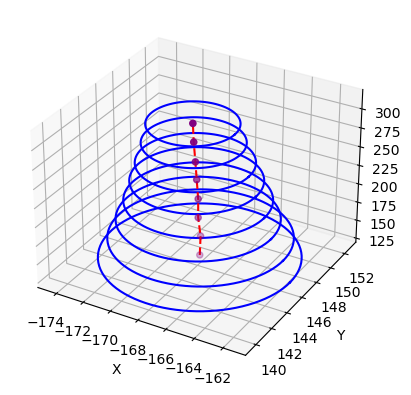

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for center in centers:
    cx, cy = center[0], center[1]
    radius = center[2]
    cz = center[3] 
    u = np.linspace(0, 2 * np.pi, 100)
    x = cx + np.cos(u) * radius
    y = cy + np.sin(u) * radius
    z = cz * np.ones_like(x)
    ax.plot(x, y, z, 'b-')


ax.scatter(centers[:, 0], centers[:, 1], centers[:, 3], color='purple', marker='o')
ax.plot(centers[:, 0], centers[:, 1], centers[:, 3], 'r--')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

Poniższy kod tworzy wykres dwuwymiarowy, na którym są rysowane okręgi na podstawie środków przechowywanych w zmiennej centers. Widoczne jest również przemieszczenie środków okręgów (czerwona linia).

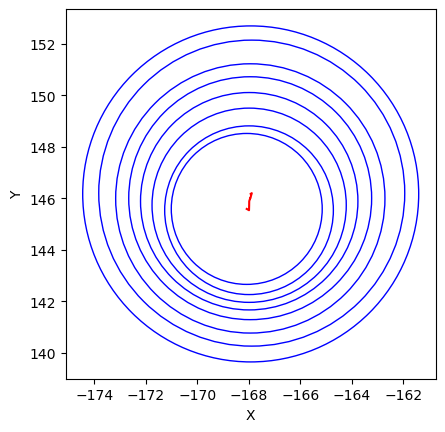

In [53]:
plt.figure()
for center in centers:
    cx, cy = center[0], center[1]
    radius = center[2]
    plt.gca().add_patch(plt.Circle((cx, cy), radius, color='b', fill=False))
plt.plot(centers[:, 0], centers[:, 1], 'r-')
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal')


plt.show()